# **Check versions**

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import seaborn as sns

for p in [np, pd, sklearn, sns]:
    print (p.__name__, p.__version__)

numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
seaborn 0.10.0


The following code has been tested in:

*   numpy 1.18.1
*   pandas 1.0.1
*   sklearn 0.22.1
*   seaborn 0.10.1

# **Summary**

In this final project, a model has been created in order to predict future sales at 1C Company, one of the largest software firms. In the EDA process, it was discovered that a lot of products and some shops were not active in the last year, therefore they were not be considered in the feature generation process. Although some information may be lost, this reduction allows training models a bit faster and with processing and resources available, without affecting the score significantly. In the feature generation lags of 1,2,3 and 12 months were used.  Finally, 17 features were created. An XGBoost model was built, getting 0.94205 in the RMSE metric with the test dataset. Then, two ensembling techniques were tested (simple mix, stacking) but it was not possible to improve the score.

In [2]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
import gc
import matplotlib.pyplot as plt
%matplotlib inline 
from itertools import product
import time

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# **EDA**

The data provided includes:

## File descriptions

- **sales_train.csv**: Train set. Daily historical data from January 2013 to October 2015
- **test.csv**: Test set. You need forecast the sales for these shops and products for November 2015
- **sample_submission.csv**: A sample submission in the correct format
- **items.csv**: Supplemental information about the items/products
- **items_categories.csv**: supplemental information about the items categories
- **shops.csv**: supplemental information about the shops

## Data fields

- **ID**:An id that represents a (Shop, Item) tuple within the test set
- **shop_id**: Unique identifier of a shop
- **item_id**: Unique identifier of a product
- **item_category_id**: Unique identifier of a item category
- **item_cnt_day**: Number of products sold. Your are predicting a monthly amount of this measure
- **item_price**: Current price of a item
- **date**: date in format dd/mm/yyyy
- **date_block_num**: A consecutive month number, used for convinience. January 2013 is 0, February 2013 is 1 ... October 2015 is 33
- **item_name**: Name of item
- **shop_name**: Name of shop
- **item_category_name**: Name of category name

In [3]:
# Import data from csv files
sales_data = pd.read_csv('sales_train.zip')
shops_data = pd.read_csv('shops.csv')
categories_data = pd.read_csv('item_categories.csv')
items_data = pd.read_csv('items.csv')
test_data = pd.read_csv('test.csv').set_index('ID')

In [4]:
print(sales_data.shape)
sales_data.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# Sum sales per day.
df = sales_data.copy()
total_per_day = df.groupby('date').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_day.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,28.12.2013,103774,315275,93436151,9.491239e+06,13343.0
1,30.12.2014,214452,309775,94418782,1.220957e+07,13236.0
2,29.12.2013,102685,315291,92980641,9.184175e+06,12863.0
3,30.12.2013,100518,302621,89671936,9.448912e+06,12823.0
4,31.12.2014,191981,275199,83384841,1.127468e+07,11394.0


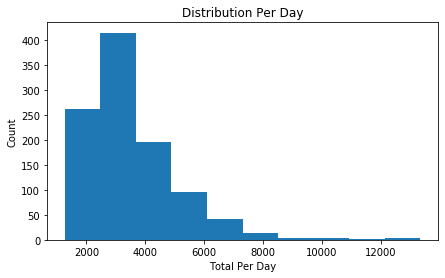

In [6]:
fig, ax = plt.subplots(figsize=(7,4))
plt.hist(total_per_day.item_cnt_day)
ax.set (xlabel = "Total Per Day",
        ylabel = "Count",
        title = "Distribution Per Day")
plt.show()

In [7]:
# Sum sales per month
total_per_month = df.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,11,4747485,1424369716,1.431799e+08,183342.0
1,23,4339498,1330492992,1.794057e+08,168755.0
2,2,4016457,1220911622,8.429831e+07,147142.0
3,8,3208314,957871641,7.270157e+07,133332.0
4,0,3417068,1183971787,8.221187e+07,131479.0


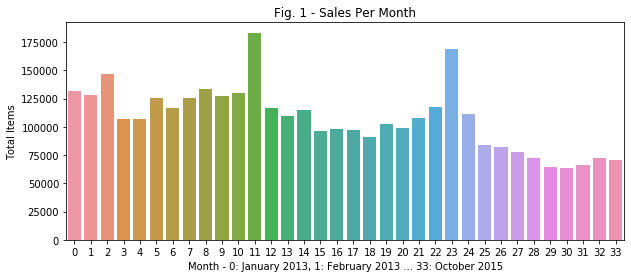

Max:183342.0
Min:63187.0
Mean:107300.17647058824


In [8]:
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(total_per_month.date_block_num, total_per_month.item_cnt_day)
ax.set (xlabel = "Month - 0: January 2013, 1: February 2013 ... 33: October 2015",
        ylabel = "Total Items",
        title = "Fig. 1 - Sales Per Month")
plt.show()
print("Max:{}".format(total_per_month.item_cnt_day.max()))
print("Min:{}".format(total_per_month.item_cnt_day.min()))
print("Mean:{}".format(total_per_month.item_cnt_day.mean()))

It can be seen that December are the months with higher sales (month 11 and 13). Also is observed that there is a trend of progressive decrease in sales year after year.

Test set is made up of (shop, item) pairs so we should explorer how is the behaviour of sales respect to the shops.

In [9]:
# Sum sales per shop
total_per_shop = df.groupby('shop_id').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_per_shop.head()

,shop_id,date_block_num,item_id,item_price,item_cnt_day
0,31,3519304,2613938432,1.707634e+08,310777.0
1,25,2803911,2017578669,1.555576e+08,241920.0
2,54,1700597,1575568395,1.096694e+08,185790.0
3,28,2106668,1503076500,1.252947e+08,184557.0
4,42,1762898,1149534465,1.015515e+08,144934.0


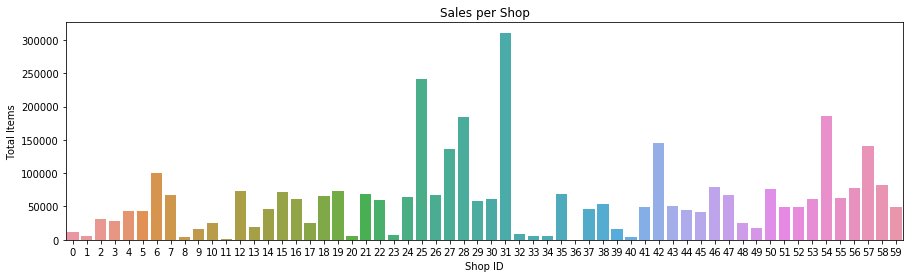

In [10]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(total_per_shop.shop_id, total_per_shop.item_cnt_day)
ax.set (xlabel = "Shop ID",
        ylabel = "Total Items",
        title = "Sales per Shop")
plt.show()

Next, it is investigate if the individual behaviour of shops over time is similar to the one observed in Fig 1. At first place, are considered the shops with less sales (i.e: shop ID 8, 40)

In [11]:
df1 = df[df['shop_id'] == 8]
total_shop_low1 = df1.groupby('date_block_num').sum().sort_values(by=['item_cnt_day'], ascending = False).reset_index()
total_shop_low1

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,11112,13864194,902495.500,1463.0
1,1,8736,11074599,721811.395,1156.0
2,2,7440,9308031,601366.810,977.0
3,3,8,4809,599.000,-1.0


There is somenthing that seems interesting. This shop was open 4 months only. This is a situation that can be found in others shops.

In [12]:
# A new feature is added to the shops_data dataframe, to identify how many months the shop was open.

shops_data_ft1 = shops_data.copy()
months_open = [len(df[df['shop_id']==x].groupby(['date_block_num']).sum()) for x in shops_data_ft1.shop_id]
shops_data_ft1['months_open'] = months_open
shops_data_ft1.head()

,shop_name,shop_id,months_open
0,"!Якутск Орджоникидзе, 56 фран",0,2
1,"!Якутск ТЦ ""Центральный"" фран",1,2
2,"Адыгея ТЦ ""Мега""",2,34
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34
4,"Волжский ТЦ ""Волга Молл""",4,34


In [13]:
len(shops_data_ft1[shops_data_ft1['months_open'] == 34])

32

Out of 60 shops, only 32 remained open for all the 34 months. But is also possible, that some new shops were opened in the last months, and remain open in the month 34. 

In [14]:
# This fetaure let us know if the shop was open in the last month of the time serie

shops_data_ft2 = shops_data_ft1
df_tempo = df[df['date_block_num'] == 33]
last_month_open = np.sort(df_tempo['shop_id'].unique())
last_month_open = [x in last_month_open for x in shops_data_ft2.shop_id]
shops_data_ft2['last_month_open'] = last_month_open
shops_data_ft2.head()

,shop_name,shop_id,months_open,last_month_open
0,"!Якутск Орджоникидзе, 56 фран",0,2,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False
2,"Адыгея ТЦ ""Мега""",2,34,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True


In [15]:
shop_range = sales_data.groupby(['shop_id']).date_block_num.agg(['min','max'])
len(shop_range[shop_range['max']<22])

6

6 shops were closed in the last year

# **Test Data**

Now, it is reviewed if the ***test set*** includes all the shops

In [16]:
len(test_data.shop_id.unique())

42

It is clear that some shops has been excluded from test data.

In [17]:
shops_data_tempo = shops_data_ft2
is_test = [x in test_data.shop_id.unique() for x in shops_data_tempo.shop_id]
shops_data_tempo['is_test'] = is_test

shops_data_tempo.head()

,shop_name,shop_id,months_open,last_month_open,is_test
0,"!Якутск Орджоникидзе, 56 фран",0,2,False,False
1,"!Якутск ТЦ ""Центральный"" фран",1,2,False,False
2,"Адыгея ТЦ ""Мега""",2,34,True,True
3,"Балашиха ТРК ""Октябрь-Киномир""",3,34,True,True
4,"Волжский ТЦ ""Волга Молл""",4,34,True,True


Acording to this, in the ***test set*** only are included the shops that are open at 34th month. The only exceptions are shops 9 y 20.

In [18]:
df_tempo = df[df['shop_id'] == 9]
total_shop_tempo = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_tempo

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,9,13392,17668038,1.617737e+06,6526.0
1,21,12753,18231529,1.839812e+06,6155.0
2,27,9,5672,3.190000e+03,-1.0
3,33,7605,13386757,1.253564e+06,3186.0


In [19]:
df_tempo = df[df['shop_id'] == 20]
total_shop_tempo = df_tempo.groupby('date_block_num').sum().sort_values(by=['date_block_num'], ascending = True).reset_index()
total_shop_tempo

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,21,18900,16550232,1.150218e+06,3261.0
1,33,16940,13563669,1.239048e+06,2611.0


Those two shops, looks like it just has been re-opened in the month 33. Therefore, the information that those two shops deliver seems not to be meaningful. 

Now, it is reviewed if the ***test set*** includes all the items that are included in the ***training set***

In [20]:
print('Items in training set %i' % len(sales_data.item_id.unique()))
print('Items in test set %i' % len(test_data.item_id.unique()))

Items in training set 21807
Items in test set 5100


In [21]:
item_range = sales_data.groupby(['item_id']).date_block_num.agg(['min','max'])
len(item_range[item_range['max']<22])

9633

9633 products were not sold in the last year

# **Feature Engineering**

In [22]:
pd.options.mode.chained_assignment = None

# Products and shops that were not active in the last year won't be considered in the training set

# Not Active Products

item_range = item_range.reset_index()
item_range_not = item_range[item_range['max']<22]
item_range_not.loc[:,'not_active_item'] = 1
sales_data_df1 = pd.merge(sales_data, item_range_not[['not_active_item','item_id']], on='item_id', how='left').fillna(0)

In [23]:
# Not active shops

shop_range = shop_range.reset_index()
shop_range_not = shop_range[shop_range['max']<22]
shop_range_not.loc[:,'not_active_shop'] = 1
sales_data_df2 = pd.merge(sales_data_df1, shop_range_not[['not_active_shop','shop_id']], on='shop_id', how='left').fillna(0)
sales_data_df3 = sales_data_df2[(sales_data_df2['not_active_item']==0) & (sales_data_df2['not_active_shop']==0)]
sales_data_df4 = sales_data_df3.drop(['not_active_item','not_active_shop'], axis=1)
print(sales_data_df4.shape)
sales_data_df4.head()

(2431608, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0
5,10.01.2013,0,25,2564,349.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0


In [24]:
## Initial Feature Matrix

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_data_df4['date_block_num'].unique():
    cur_shops = sales_data_df4.loc[sales_data_df4['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_data_df4.loc[sales_data_df4['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Create target
gb = sales_data_df4.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target'}, axis = 1, inplace =True)
all_data = pd.merge(grid, gb, how='left', on=index_cols)

all_data['target'] = (all_data['target']
                            .fillna(0)
                            .clip(0,20))

# Integrate test data with train data

test_data['date_block_num'] = 34
all_data = pd.concat([all_data, test_data], ignore_index=True, sort=False, keys=index_cols)
all_data.fillna(0, inplace=True) # 34 month

In [25]:
# Other Features

gb = sales_data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_shop'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

gb = sales_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename({'item_cnt_day':'target_item'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

gb = sales_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'mean'})
gb.rename({'item_cnt_day':'target_item_mean'}, axis = 1, inplace =True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [26]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))

In [27]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_mean
0,59,22154,0,1.0,2017.0,18.0,1.000000
1,59,2552,0,0.0,2017.0,0.0,0.000000
2,59,2564,0,0.0,2017.0,5.0,1.000000
3,59,2574,0,2.0,2017.0,119.0,1.144231
4,59,2607,0,0.0,2017.0,29.0,1.000000


In [28]:
## Time lag features

shift_range = [1, 2, 3, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}_f'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [29]:
# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1]=='f'] 

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items_data[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)

gc.collect();

# **XGBoost Model**

In [30]:
# Max lag 12 months, first 12 months are not considered
all_data_df1 = all_data[all_data['date_block_num'] > 11]  
print(all_data_df1.shape)
all_data_df1.head()

(5870299, 24)


,shop_id,item_id,date_block_num,target,target_shop,target_item,target_item_mean,target_lag_1_f,target_item_lag_1_f,target_item_mean_lag_1_f,target_shop_lag_1_f,target_lag_2_f,target_item_lag_2_f,target_item_mean_lag_2_f,target_shop_lag_2_f,target_lag_3_f,target_item_lag_3_f,target_item_mean_lag_3_f,target_shop_lag_3_f,target_lag_12_f,target_item_lag_12_f,target_item_mean_lag_12_f,target_shop_lag_12_f,item_category_id
1928302,54,10297,12,4.0,8198.0,23.0,1.000000,3.0,42.0,1.000000,10055.0,0.0,2.0,1.000000,7978.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,37
1928303,54,10296,12,3.0,8198.0,17.0,1.000000,0.0,24.0,1.000000,10055.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,38
1928304,54,10298,12,14.0,8198.0,182.0,1.181818,20.0,369.0,1.308511,10055.0,20.0,1309.0,2.226191,7978.0,7.0,144.0,2.526316,6676.0,0.0,0.0,0.0,0.0,40
1928305,54,10300,12,3.0,8198.0,26.0,0.962963,1.0,54.0,1.058824,10055.0,20.0,361.0,1.367424,7978.0,0.0,53.0,1.606061,6676.0,0.0,0.0,0.0,0.0,37
1928306,54,10284,12,1.0,8198.0,3.0,1.000000,0.0,4.0,1.000000,10055.0,0.0,3.0,1.000000,7978.0,0.0,5.0,1.000000,6676.0,0.0,0.0,0.0,0.0,57


In [31]:
# Training/Validation/Test Split

dates = all_data_df1['date_block_num']

last_block = dates.max()

dates_train = dates[dates <  last_block-1]
dates_val  = dates[dates == last_block-1]
dates_test  = dates[dates == last_block]

X_train = all_data_df1.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_val =  all_data_df1.loc[dates == last_block-1].drop(to_drop_cols, axis=1)
X_test = all_data_df1.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data_df1.loc[dates <  last_block-1, 'target'].values
y_val =  all_data_df1.loc[dates == last_block-1, 'target'].values
y_test =  all_data_df1.loc[dates == last_block, 'target'].values

In [32]:
# XGboost training takes  about 1.18 hours  (8CPU 32GB RAM). The serialized model is available in the next cell

ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False, 
    early_stopping_rounds = 10)

time.time() - ts

[17:58:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:58:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


4250.455169916153

In [33]:
#import pickle

# Serialized model
#model = pickle.load(open('XGBFrstLevel.pickle' , 'rb'))

In [34]:
pred_xgb = model.predict(X_val)
rmse_cl = np.sqrt(mean_squared_error(y_val, pred_xgb))
print(rmse_cl)

0.92093885


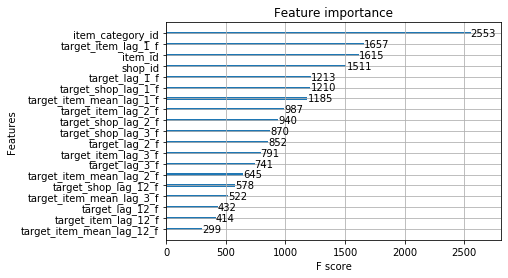

In [35]:
from xgboost import plot_importance
from matplotlib import pyplot

#Feature Importance

plot_importance(model)
pyplot.show()

In [36]:
y_test = model.predict(X_test)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": y_test
})
submission.to_csv('final_submission.csv', index=False)

# **Ensembling**

In [37]:
del model
gc.collect();

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)

rmse_cl = np.sqrt(mean_squared_error(y_val, pred_lr))
print(rmse_cl)

0.9715805128673884


In [38]:
X_val_level2 = np.c_[pred_lr, pred_xgb] 

In [39]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [40]:
#Second Level Feature Matrix process takes about 3.43 hours  (8CPU 32GB RAM). 
#The serialized meta-features are available in the next cell

ts = time.time()

del lr 
gc.collect();

# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)   

    X_tr = X_train[dates_train <  cur_block_num]
    X_vl = X_train[dates_train == cur_block_num]

    y_tr = y_train[dates_train <  cur_block_num]
    y_vl = y_train[dates_train == cur_block_num]
    
    lr1 = LinearRegression()
    lr1.fit(X_tr.values, y_tr)
    pred_lr1 = lr1.predict(X_vl.values)
    
    model2 = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)

    model2.fit(
        X_tr, 
        y_tr, 
        eval_metric="rmse", 
        eval_set=[(X_tr, y_tr), (X_vl, y_vl)], 
        verbose=False, 
        early_stopping_rounds = 10)
    
    pred_xgb2 = model2.predict(X_vl)
    
    X_ts_tmp = np.c_[pred_lr1, pred_xgb2]
    
    if cur_block_num == 27:
        X_train_level2 = X_ts_tmp
    else:
        X_train_level2 = np.concatenate((X_train_level2, X_ts_tmp), axis=0)
    
    del model2, lr1 
    gc.collect();

time.time() - ts

27
[19:09:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
28
[19:16:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:16:35] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
29
[19:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:41] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
30
[20:12:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:15] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use 

12348.1933426857

In [41]:
# Serialized Meta-Features
#X_train_level2 = pickle.load(open('X_train_level2.pickle' , 'rb'))

In [42]:
# Simple Mix

alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = 0
best_rmse = 4
for alpha in alphas_to_try:
    mix = alpha*(X_train_level2[:,0]) + (1 - alpha)*(X_train_level2[:,1])
    rmse_opt = np.sqrt(mean_squared_error(y_train_level2, mix))
    if rmse_opt < best_rmse:
        best_rmse = rmse_opt
        best_alpha = alpha

rmse_train_simple_mix = best_rmse

print('Best alpha: %f; Corresponding rmse on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 0.000000; Corresponding rmse on train: 0.814113


In [43]:
val_preds = best_alpha*(X_val_level2[:,0]) + (1 - best_alpha)*(X_val_level2[:,1]) 
rmse_test_simple_mix = np.sqrt(mean_squared_error(y_val, val_preds)) 

print('Test rmse for simple mix is %f' % rmse_test_simple_mix)

Test rmse for simple mix is 0.920939


In [44]:
# Stacking

lr2 = LinearRegression()
lr2.fit(X_train_level2, y_train_level2)
train_preds = lr2.predict(X_train_level2)
rmse_train_stacking = np.sqrt(mean_squared_error(y_train_level2, train_preds)) 

val_preds = lr2.predict(X_val_level2)
rmse_test_stacking = np.sqrt(mean_squared_error(y_val, val_preds)) 

print('Train rmse for stacking is %f' % rmse_train_stacking)
print('Validation rmse for stacking is %f' % rmse_test_stacking)

Train rmse for stacking is 0.814067
Validation rmse for stacking is 0.921299


# **Future work**

From RMSE values obtained in the train and validation dataset, it is observed that models trained undergo overfitting. Cross-validation and other techniques should be tested in order to overcome this problem. Also, new features must be searched in order to get a simpler model with a better score. Finally, ensembling techniques that include neural networks could be implemented and observe their impact on the metric evaluated.